![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
estadisticas_s = bikes.groupby('season')['total'].agg([
    'mean',     # Promedio
    'max',      # Máximo
    'min',      # Mínimo
    'std',      # Desviación estándar
    'median',   # Mediana (percentil 50)
    lambda x: x.quantile(0.25),  # Percentil 25
    lambda x: x.quantile(0.75),  # Percentil 75
])

# Renombra las columnas generadas por las funciones lambda para claridad
estadisticas_s = estadisticas_s.rename(columns={
    '<lambda_0>': 'percentil_25',
    '<lambda_1>': 'percentil_75'
})

# Muestra el resultado
print(estadisticas_s)

              mean  max  min         std  median  percentil_25  percentil_75
season                                                                      
1       116.343261  801    1  125.273974    78.0          24.0         164.0
2       215.251372  873    1  192.007843   172.0          49.0         321.0
3       234.417124  977    1  197.151001   195.0          68.0         347.0
4       198.988296  948    1  177.622409   161.0          51.0         294.0


**Analísis Descriptivo Variable "Season":**

El verano (3) presenta el promedio más alto de alquileres (234.42), seguido de cerca por la primavera (215.25), lo cual sugiere que estos periodos son los más populares para el alquiler de bicicletas. El otoño (198.99) y el invierno (116.34) muestran una demanda menor, siendo el invierno el periodo con la menor actividad.El verano también tiene la desviación estándar más alta (197.15), indicando una mayor variabilidad en los alquileres diarios. Esto podría sugerir que, aunque el verano es popular, la demanda es más impredecible, posiblemente influenciada por el clima extremo o eventos especiales.Todas las temporadas registran un mínimo de 1, lo que indica días de muy baja demanda. Los máximos varían, con el verano alcanzando el valor más alto (977), lo cual refuerza la idea de que es la temporada con picos de mayor demanda. La mediana sigue un patrón similar al promedio, siendo más alta en verano y primavera, lo que refleja una mayor demanda media durante estos periodos. Los rangos intercuartílicos son más amplios en las temporadas de verano y primavera, lo que sugiere una mayor dispersión en los datos de alquileres durante estos periodos.


El verano y la primavera presentan la mayor demanda de alquileres de bicicletas, lo que podría estar relacionado con el clima más cálido y agradable, que fomenta actividades al aire libre y el uso de bicicletas para el transporte y recreación.El invierno muestra significativamente menos actividad en comparación con las demás estaciones, lo cual es esperable dadas las condiciones climáticas más frías, que desalientan el uso de bicicletas.Aunque el verano tiene la demanda más alta, también presenta la mayor variabilidad, lo que indica que los factores externos podrían influir considerablemente en el número de alquileres diarios. La planificación de eventos, promociones, o mejoras en la infraestructura para estos meses podría ayudar a estabilizar y potenciar la demanda.El invierno representa una oportunidad para estrategias dirigidas a aumentar el uso de bicicletas, como la implementación de programas de incentivos, mejoras en el equipo para el frío, o campañas de marketing que promuevan el ciclismo en condiciones invernales.

In [6]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [7]:
estadisticas_h = bikes.groupby('hour')['total'].agg([
    'mean',     # Promedio
    'max',      # Máximo
    'min',      # Mínimo
    'std',      # Desviación estándar
    'median',   # Mediana (percentil 50)
    lambda x: x.quantile(0.25),  # Percentil 25
    lambda x: x.quantile(0.75),  # Percentil 75
])

# Renombra las columnas generadas por las funciones lambda para claridad
estadisticas_h = estadisticas_h.rename(columns={
    '<lambda_0>': 'percentil_25',
    '<lambda_1>': 'percentil_75'
})

# Muestra el resultado
print(estadisticas_h)

            mean  max  min         std  median  percentil_25  percentil_75
hour                                                                      
0      55.138462  283    2   43.620012    41.0         24.00         74.50
1      33.859031  168    1   34.112105    19.0         11.00         46.00
2      22.899554  119    1   26.110267    11.0          5.00         32.00
3      11.757506   66    1   12.666442     6.0          3.00         15.00
4       6.407240   28    1    4.217633     6.0          3.00          9.00
5      19.767699   57    1   12.784293    19.0          8.00         29.00
6      76.259341  213    1   54.745333    75.0         24.50        118.00
7     213.116484  596    1  159.207044   208.0         63.00        334.00
8     362.769231  839    8  231.723065   392.0        133.50        563.50
9     221.780220  414   14   92.099209   217.0        161.00        294.50
10    175.092308  539   17  101.807629   149.0        106.00        218.50
11    210.674725  647   1

**Analísis Descriptivo Variable "Hour":**

Entre las 17 y 18 horas, destaca como el momento de mayor actividad, con un promedio impresionante de 468.77 y 430.86 alquileres respectivamente. Estas horas, justo cuando la gente sale del trabajo o de sus actividades diarias, muestran la preferencia por la bicicleta como medio para regresar a casa o para actividades de ocio al final del día. La máxima demanda se observa a las 18 horas con 977 alquileres, lo que indica no solo la popularidad sino también la variabilidad de la demanda, posiblemente influenciada por eventos especiales o cambios en el clima. La desviación estándar alta en estas horas (223.78 y 219.91 respectivamente) subraya esta variabilidad.Por la mañana, entre las 7 y 8 horas, hay un resurgimiento notable en el uso de bicicletas, alcanzando un promedio de 213.12 y 362.77 alquileres respectivamente. Esto refleja claramente la preferencia por las bicicletas como medio de transporte al trabajo o la escuela. La demanda pico de la mañana a las 8 horas, con un máximo de 839 alquileres, muestra una menor variabilidad que en la tarde, pero aún así destaca la importancia de estas horas en el día a día de los usuarios.

Durante las horas nocturnas, desde la medianoche hasta las 5 de la mañana, vemos la menor actividad, con un promedio que va disminuyendo hasta llegar a un mínimo de 6.41 alquileres a las 4 horas. Esto es esperable, dado el menor tráfico y la reducida necesidad de transporte en estas horas. Sin embargo, el hecho de que aún haya gente alquilando bicicletas, incluso en el mínimo de la noche, habla de la diversidad de necesidades y estilos de vida de los usuarios.Durante el resto del día, la actividad se mantiene estable con una ligera tendencia ascendente hacia las horas de la tarde. Las 10 y 11 horas muestran una actividad intermedia, con promedios de 175.09 y 210.67 alquileres respectivamente, lo que podría corresponder a usuarios que inician actividades más tarde o utilizan las bicicletas para tareas a media mañana.

En resumen, el análisis revela dos picos claros de demanda: uno en la mañana y otro más pronunciado al final de la tarde, lo que subraya el rol de las bicicletas como medio de transporte esencial para el inicio y fin de la jornada laboral o escolar. Las altas variabilidades observadas, especialmente en las horas pico, sugieren una demanda influenciada por factores externos como el clima y eventos específicos. Las horas nocturnas, aunque menos activas, revelan un uso continuo del servicio, posiblemente por trabajadores nocturnos o por opciones de ocio. Este patrón diurno en el alquiler de bicicletas proporciona insights valiosos para ajustar la disponibilidad de bicicletas y mejorar los servicios de acuerdo a las necesidades de los usuarios en diferentes momentos del día.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:title={'center':'Promedio de Bicicletas Rentadas por Hora'}, xlabel='hour'>

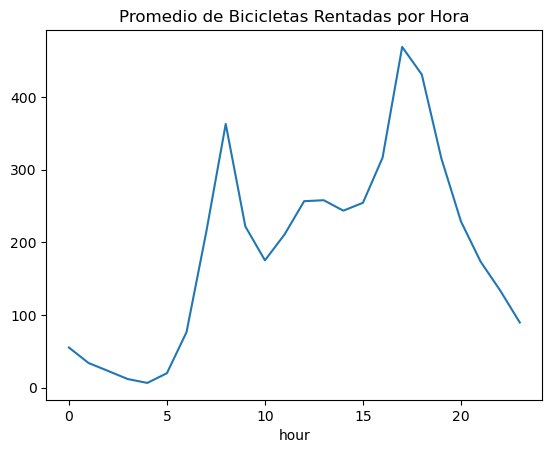

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot(title='Promedio de Bicicletas Rentadas por Hora')

<AxesSubplot:title={'center':'Promedio de Bicicletas Rentadas por Hora en Invierno'}, xlabel='hour'>

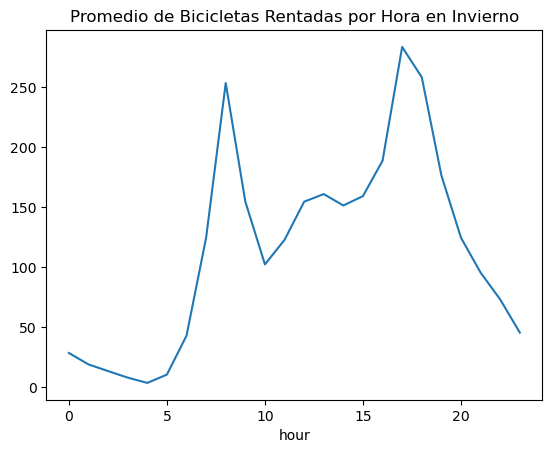

In [9]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
# Filtra los datos para incluir solo la temporada de invierno (season == 1)
bikes_invierno = bikes[bikes['season'] == 1]

# Agrupa por 'hour', calcula el promedio de 'total', y traza el gráfico
bikes_invierno.groupby('hour').total.mean().plot(title='Promedio de Bicicletas Rentadas por Hora en Invierno')

<AxesSubplot:title={'center':'Promedio de Bicicletas Rentadas por Hora en Verano'}, xlabel='hour'>

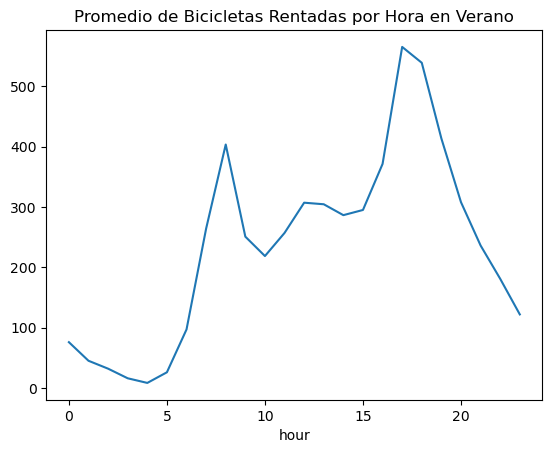

In [10]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
# Filtra los datos para incluir solo la temporada de verano (season == 3)
bikes_verano = bikes[bikes['season'] == 3]

# Agrupa por 'hour', calcula el promedio de 'total', y traza el gráfico
bikes_verano.groupby('hour')['total'].mean().plot(title='Promedio de Bicicletas Rentadas por Hora en Verano')

Tanto en invierno como en verano, hay dos picos pronunciados de actividad, uno por la mañana entre las 7 y las 9, y otro por la tarde entre las 16 y las 18 horas. Estos picos corresponden probablemente a las horas de inicio y fin de la jornada laboral o escolar, indicando que las bicicletas se utilizan significativamente para los desplazamientos pendulares. La gráfica de verano muestra una mayor cantidad de alquileres promedio en comparación con el invierno, lo que refleja la tendencia general de mayor uso de bicicletas en climas más cálidos.Además, el pico de la tarde en verano es mucho más alto y pronunciado que en invierno, lo que puede indicar una mayor propensión a actividades de ocio después del trabajo cuando el clima es agradable.La gráfica de invierno, aunque sigue mostrando un uso significativo, tiene picos más moderados y un declive más notable después de las horas pico de la tarde.

Durante las horas nocturnas, la actividad es mínima en ambas temporadas, con la gráfica de invierno mostrando incluso menos alquileres promedio, posiblemente debido a la combinación de oscuridad y frío. A partir de las 5 de la mañana, ambas gráficas empiezan a mostrar un aumento en la actividad, que se acelera significativamente al acercarse a las 7 de la mañana.

El rango de alquileres en la gráfica de verano es más amplio que en la de invierno, lo que sugiere una mayor variabilidad en el número de alquileres hora por hora durante los meses más cálidos.Este patrón podría ser el resultado de más actividades al aire libre en verano, así como la influencia de las vacaciones escolares y eventos especiales que pueden afectar los patrones de movilidad.En ambas gráficas, las horas con menos actividad son consistentes, mostrando el menor número de alquileres alrededor de las 4 de la mañana, lo cual es comprensible considerando las horas habituales de sueño y la baja necesidad de transporte.

Estos patrones horarios enfatizan la importancia de gestionar la disponibilidad de bicicletas para satisfacer la demanda en las horas pico, y también podrían ser una base para incentivar el uso de bicicletas durante las horas de menor actividad, quizás con tarifas reducidas o programas especiales. El conocimiento de estos patrones también puede ser útil para el mantenimiento preventivo de las bicicletas y la planificación de la logística de redistribución. Finalmente, las diferencias entre las estaciones destacan la influencia del clima en los patrones de movilidad urbana y pueden guiar la toma de decisiones estratégicas en términos de marketing y operaciones para el sistema de alquiler de bicicletas.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [11]:
# Celda 3
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

season_dummies = pd.get_dummies(bikes['season'], prefix='season', drop_first=True)

X = pd.concat([bikes['hour'], season_dummies], axis=1)
y = bikes['total']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Creamos el modelo de regresión lineal
model = LinearRegression()

# Ajustamos el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluamos el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimimos los resultados
print(f"Coeficientes: {model.coef_}")
print(f"Intercepto: {model.intercept_}")
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coefficiente de Determinación (R^2): {r2}")

# Si necesitas los nombres de las columnas de las variables dummy:
feature_names = X.columns
print(f"Nombres de las Características: {feature_names}")

Coeficientes: [ 10.62873885 100.90776793 119.01866421  87.2473903 ]
Intercepto: -9.563071266089025
Error Cuadrático Medio (MSE): 25644.421108938277
Coefficiente de Determinación (R^2): 0.21517712032533343
Nombres de las Características: Index(['hour', 'season_2', 'season_3', 'season_4'], dtype='object')


**Interpretación de los Coeficientes:**
- **Coeficiente para 'hour'**: Por cada hora adicional, el número de bicicletas rentadas aumenta en promedio por 10.63 unidades. Este efecto es mantenido sin importar la temporada.
- **Coeficiente para 'season_2'**: En la primavera, el número de bicicletas rentadas aumenta en 100.91 unidades en promedio en comparación con el invierno (que es la categoría de referencia).
- **Coeficiente para 'season_3'**: En el verano, hay un aumento de 119.02 unidades en el número promedio de bicicletas rentadas en comparación con el invierno.
- **Coeficiente para 'season_4'**: En el otoño, el número de bicicletas rentadas aumenta en promedio por 87.25 unidades en comparación con el invierno.
- **El intercepto de -9.56** es el punto de partida del modelo; sin embargo, un intercepto negativo no tiene una interpretación práctica directa en este contexto porque no puede haber un número negativo de bicicletas rentadas. Esto podría sugerir que el modelo no está capturando completamente la base de la relación entre las horas, las temporadas y el número de bicicletas rentadas.

**Interpretación de las Métricas de Desempeño:**
- **MSE (25644.42)**: El Error Cuadrático Medio es una medida de la calidad del estimador; es siempre no negativo, y los valores más bajos son mejores. Un MSE de 25644.42 es relativamente alto, lo cual puede indicar que hay una variabilidad significativa en los datos que el modelo no está capturando.
- **R-^2 (0.215)**:  Un R^2 de 0.215 sugiere que solo el 21.5% de la variabilidad en el número de bicicletas rentadas es explicada por la hora del día y la temporada. Esto deja una gran cantidad de variabilidad sin explicar, lo que sugiere que hay otros factores no incluidos en el modelo que influyen en la cantidad de alquileres de bicicletas.

Dado que el R^2 es relativamente bajo, hay varias posibles interpretaciones: Puede haber otras variables importantes que afectan al total de alquileres de bicicletas, como el clima (temperatura, precipitación), días de la semana, o factores económicos que no están incluidos en el modelo; las relaciones entre las horas, las temporadas y los alquileres de bicicletas pueden no ser lineales y podrían requerir un enfoque de modelado más complejo; puede haber ruido en los datos o valores atípicos que están afectando la capacidad del modelo para ajustar y predecir con precisión.

El modelo de regresión lineal que hemos aplicado enfrenta limitaciones dada la complejidad inherente al alquiler de bicicletas. Este modelo asume una relación directa y constante entre la hora y la temporada con los alquileres, lo cual es una simplificación que no refleja posibles relaciones no lineales ni la influencia de otros factores no incluidos como el clima o días especiales. Además, no capta la posible correlación entre observaciones sucesivas ni las interacciones entre variables, como las horas pico varían por temporada. Por último, los valores atípicos y la variabilidad de errores que cambia con el nivel de demanda (heterocedasticidad) pueden afectar la precisión del modelo, y la multicolinealidad entre predictores podría estar distorsionando los resultados. Estos aspectos destacan la necesidad de considerar métodos más avanzados o modelos no lineales para una representación más fiel de la dinámica de alquiler de bicicletas.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [12]:
# Celda 4

# Utilizar la reducción de la varianza como criterio. La varianza es un criterio apropiado cuando la variable de salida es continua
def variance(y):
    if len(y) == 0:  # para evitar divisiones por cero
        return 0
    return y.var(ddof=0)  # ddof=0 para la varianza poblacional

# Definición de la función para calcular la reducción de la varianza para un punto de corte dado
def variance_reduction(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n = len(y)
    n_l = len(y_l)
    n_r = n - n_l

    # Ponderar la varianza de los dos nodos
    weighted_var = (n_l / n) * variance(y_l) + (n_r / n) * variance(y_r)
    
    # Reducción de la varianza es la varianza total menos la ponderada
    var_reduction = variance(y) - weighted_var
    
    return var_reduction

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    best_split = [0, 0, -np.inf]  # j, split, gain
    
    # Para todas las variables 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]  # remover duplicados y evitar el mínimo
        
        # Para cada partición
        for split in splits:
            gain = variance_reduction(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        return {'y_pred': y.iloc[0], 'level': level, 'split': -1, 'n_samples': 1, 'gain': 0}
    
    # Si no hay varianza, no se puede hacer más splits
    if variance(y) == 0:
        return {'y_pred': y.iloc[0], 'level': level, 'split': -1, 'n_samples': len(y), 'gain': 0}

    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()

    tree = {'y_pred': y_pred, 'level': level, 'split': -1, 'n_samples': X.shape[0], 'gain': gain}
    
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None and level >= max_depth:
        return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)
print(tree)


{'y_pred': 191.57413191254824, 'level': 0, 'split': [0, 8.0], 'n_samples': 10886, 'gain': 9134.405911766378, 'sl': {'y_pred': 55.437673900946024, 'level': 1, 'split': [0, 7.0], 'n_samples': 3594, 'gain': 3603.850329979806, 'sl': {'y_pred': 32.58203249442498, 'level': 2, 'split': [0, 6.0], 'n_samples': 3139, 'gain': 323.4004463794806, 'sl': {'y_pred': 25.177719821162444, 'level': 3, 'split': [0, 2.0], 'n_samples': 2684, 'gain': 191.40441543022723, 'sl': {'y_pred': 44.51045104510451, 'level': 4, 'split': [0, 1.0], 'n_samples': 909, 'gain': 113.20340574084503, 'sl': {'y_pred': 55.13846153846154, 'level': 5, 'split': [2, 1.0], 'n_samples': 455, 'gain': 141.0014271019129, 'sl': {'y_pred': 48.27272727272727, 'level': 6, 'split': -1, 'n_samples': 341, 'gain': 52.2589672199947}, 'sr': {'y_pred': 75.67543859649123, 'level': 6, 'split': -1, 'n_samples': 114, 'gain': -inf}}, 'sr': {'y_pred': 33.859030837004404, 'level': 5, 'split': [2, 1.0], 'n_samples': 454, 'gain': 39.89892308426397, 'sl': {'y_

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [13]:
# Celda 5
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

# Asumiendo que 'bikes' es tu DataFrame y ya está definido
season_dummies = pd.get_dummies(bikes['season'], prefix='season', drop_first=True)

X = pd.concat([bikes['hour'], season_dummies], axis=1)
y = bikes['total']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Creamos el modelo de árbol de decisión
model = DecisionTreeRegressor(max_depth=6, random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluamos el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Imprimimos los resultados de evaluación
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R^2): {r2}")

# Imprimir la importancia de las características
feature_names = X.columns
print(" ")
print(f"Importancia de las Características:")
print(list(zip(feature_names, model.feature_importances_)))

Error Cuadrático Medio (MSE): 14979.867384991028
Coeficiente de Determinación (R^2): 0.5415555450329284
 
Importancia de las Características:
[('hour', 0.8875343356454753), ('season_2', 0.026388305053204542), ('season_3', 0.04921411540298211), ('season_4', 0.0368632438983379)]


Comparando el modelo de regresión lineal y el árbol de decisión en términos de su desempeño en un conjunto de datos, observamos que el árbol de decisión ofrece resultados superiores. Con un MSE significativamente más bajo e igual a 14979.87 y un coeficiente de determinación (R^2) más del doble que el de la regresión lineal e igual a 0.542. El árbol de decisión muestra una mayor precisión en sus predicciones y una mejor capacidad para explicar la variabilidad de la variable objetivo. Este mejor desempeño puede atribuirse a la capacidad del árbol de decisión para capturar relaciones no lineales y más complejas entre las variables, algo que el modelo de regresión lineal, con su suposición de linealidad, no puede hacer tan eficazmente.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [14]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [15]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [16]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [17]:
# Celda 6
# Crear y entrenar el modelo de árbol de decisión y el modelo de regresión logística
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

tree_clf = DecisionTreeClassifier(max_depth=5, random_state=1)  # Calibración simple del parámetro max_depth
tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)

accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree, average='weighted')

print(f"Árbol de Decisión - Accuracy: {accuracy_tree}, F1-Score: {f1_tree}")

Árbol de Decisión - Accuracy: 0.6373333333333333, F1-Score: 0.6356534568536628


In [18]:
log_reg = LogisticRegression(max_iter=1000, random_state=1)
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)

accuracy_log = accuracy_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)

print(f"Regresión Logística - Accuracy: {accuracy_log}, F1-Score: {f1_log}")

Regresión Logística - Accuracy: 0.62, F1-Score: 0.6074380165289257


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [19]:
# Celda 7
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.base import clone

# Parámetros iniciales
n_estimators = 100
np.random.seed(123)  # Esto debería ser np.random.seed(123) para usar numpy directamente.
n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
seeds = np.random.randint(1, 10000, size=n_estimators)
tree_max_depth = 5  # Profundidad máxima para el primer conjunto de árboles.
tree_min_samples_leaf = 4  # Mínimo número de muestras por hoja para el segundo conjunto de árboles.

# Listas para almacenar modelos.
models_max_depth = []
models_min_samples_leaf = []
models_log_reg = []

# Entrenamiento de los 100 árboles de decisión con max_depth especificado.
for i in range(n_estimators):
    model = DecisionTreeClassifier(max_depth=tree_max_depth, random_state=seeds[i])
    model.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    models_max_depth.append(model)

# Entrenamiento de los 100 árboles de decisión con min_samples_leaf especificado.
for i in range(n_estimators):
    model = DecisionTreeClassifier(min_samples_leaf=tree_min_samples_leaf, random_state=seeds[i])
    model.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    models_min_samples_leaf.append(model) 

# Entrenamiento de las 100 regresiones logísticas.
for i in range(n_estimators):
    model = LogisticRegression(max_iter=1000, random_state=seeds[i], solver='liblinear')  # 'solver' es específicado para asegurar convergencia en regresión logística.
    model.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    models_log_reg.append(model)

In [20]:
from sklearn.metrics import accuracy_score, f1_score

# Función para obtener las predicciones de una lista de modelos
def get_predictions(models, X):
    predictions = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X)
    return predictions

# Obtener las predicciones para cada conjunto de modelos
predictions_max_depth = get_predictions(models_max_depth, X_test)
predictions_min_samples_leaf = get_predictions(models_min_samples_leaf, X_test)
predictions_log_reg = get_predictions(models_log_reg, X_test)

# Función para calcular la votación mayoritaria y evaluar
def evaluate_ensemble(predictions, y_true):
    # Votación mayoritaria
    predictions_majority = np.round(predictions.mean(axis=1)).astype(int)
    # Cálculo de métricas
    accuracy = accuracy_score(y_true, predictions_majority)
    f1 = f1_score(y_true, predictions_majority)
    return accuracy, f1

# Evaluar cada conjunto de modelos
accuracy_max_depth, f1_max_depth = evaluate_ensemble(predictions_max_depth, y_test)
accuracy_min_samples_leaf, f1_min_samples_leaf = evaluate_ensemble(predictions_min_samples_leaf, y_test)
accuracy_log_reg, f1_log_reg = evaluate_ensemble(predictions_log_reg, y_test)

print(f"Árbol max_depth - Accuracy: {accuracy_max_depth}, F1-Score: {f1_max_depth}")
print(f"Árbol min_samples_leaf - Accuracy: {accuracy_min_samples_leaf}, F1-Score: {f1_min_samples_leaf}")
print(f"Regresión Logística - Accuracy: {accuracy_log_reg}, F1-Score: {f1_log_reg}")


Árbol max_depth - Accuracy: 0.656, F1-Score: 0.6518218623481782
Árbol min_samples_leaf - Accuracy: 0.644, F1-Score: 0.6239436619718309
Regresión Logística - Accuracy: 0.6286666666666667, F1-Score: 0.6123869171885873


In [21]:
# Combinar todas las predicciones
all_predictions = np.hstack((predictions_max_depth, predictions_min_samples_leaf, predictions_log_reg))

# Realizar votación mayoritaria para el ensamble completo
accuracy_ensemble, f1_ensemble = evaluate_ensemble(all_predictions, y_test)

print(f"Ensamble Votación Mayoritaria - Accuracy: {accuracy_ensemble}, F1-Score: {f1_ensemble}")


Ensamble Votación Mayoritaria - Accuracy: 0.6393333333333333, F1-Score: 0.6266390614216701


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [22]:
# Celda 8
# Función para obtener predicciones probabilísticas de una lista de modelos
def get_proba_predictions(models, X):
    proba_predictions = np.zeros((X.shape[0], 2, len(models)))
    for i, model in enumerate(models):
        proba_predictions[:, :, i] = model.predict_proba(X)
    return proba_predictions

# Obtener las predicciones probabilísticas para cada conjunto de modelos
proba_predictions_max_depth = get_proba_predictions(models_max_depth, X_test)
proba_predictions_min_samples_leaf = get_proba_predictions(models_min_samples_leaf, X_test)
proba_predictions_log_reg = get_proba_predictions(models_log_reg, X_test)

In [23]:
# Combinar las predicciones probabilísticas ponderadas
combined_proba = (np.mean(proba_predictions_max_depth, axis=2) + 
                  np.mean(proba_predictions_min_samples_leaf, axis=2) + 
                  np.mean(proba_predictions_log_reg, axis=2)) / 3

# Convertir las probabilidades combinadas en predicciones finales
y_pred_weighted = np.argmax(combined_proba, axis=1)

In [24]:
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
f1_weighted = f1_score(y_test, y_pred_weighted)

print(f"Ensamble Votación Ponderada - Accuracy: {accuracy_weighted}, F1-Score: {f1_weighted}")

Ensamble Votación Ponderada - Accuracy: 0.6513333333333333, F1-Score: 0.6501672240802676


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

**Respuesta:**

En el ensamble por votación mayoritaria, notamos que el desempeño del ensamble (Accuracy: 0.639, F1-Score: 0.627) se sitúa entre los desempeños individuales de los modelos componentes. Es interesante observar que el árbol de decisión con max_depth específico ofrece el mejor rendimiento individual (Accuracy: 0.656, F1-Score: 0.652), incluso superando al ensamble. Esto podría indicar que, aunque la votación mayoritaria tiene el potencial de mejorar la robustez mediante la combinación de múltiples modelos, no necesariamente garantiza una mejora en el rendimiento sobre el mejor modelo individual en todos los casos. Con la votación ponderada, el ensamble mejora ligeramente en comparación con la votación mayoritaria, alcanzando una Accuracy de 0.651 y un F1-Score de 0.650. Esta mejora sugiere que asignar pesos a las predicciones de los modelos, basándose posiblemente en su confiabilidad o desempeño, puede ofrecer una ventaja al concentrarse más en los modelos que probablemente proporcionen mejores predicciones.

La elección entre votación mayoritaria y votación ponderada debe basarse en el equilibrio entre la simplicidad y la búsqueda de un desempeño óptimo. La votación ponderada tiene el potencial de ofrecer mejoras en el rendimiento al considerar la calidad de los modelos componentes, pero esto viene con la complejidad adicional de determinar los pesos adecuados. Por otro lado, la votación mayoritaria, con su simplicidad y robustez inherente, sigue siendo una estrategia valiosa, especialmente cuando los modelos componentes tienen un desempeño similar o cuando se desea evitar el riesgo de sobreajuste.